# Анализ бизнес процессов

<div class="alert alert-block alert-info"> 
Имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года (данные о посещениях, выгрузка их покупок, рекламные расходы). Необходимо разобраться в причинах того, что несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки, и помочь компании выйти в плюс.

<br> Для выполнения задачи узнаем:
 - откуда приходят пользователи и какими устройствами они пользуются
 - сколько стоит привлечение пользователей из различных рекламных каналов
 - сколько денег приносит каждый клиент
 - когда расходы на привлечение клиента окупаются
 - какие факторы мешают привлечению клиентов

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Шаг 1. Загрузка данных

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import plotly.express as px

In [3]:
visits = pd.read_csv('visits_info_short.csv') 
orders = pd.read_csv('orders_info_short.csv') 
costs = pd.read_csv('costs_info_short.csv') 

In [4]:
def first_step(df):
    # Проверим наличие пропусков
    missing_values = df.isnull().sum()
    print("Пропущенные значения:", missing_values.sum())

    # Проверим наличие дубликатов
    duplicate_values = df.duplicated().sum()
    print("Количество дубликатов:", duplicate_values)

    # Изменим названия столбцов
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    print(df.head())

1. Изучим данные визитов и приведем данные к нужным типам.

In [5]:
first_step(visits)

Пропущенные значения: 0
Количество дубликатов: 0
        user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  


In [6]:
#visits.info()
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

2. Изучим данные заказов и приведем данные к нужным типам.

In [7]:
first_step(orders)

Пропущенные значения: 0
Количество дубликатов: 0
        user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99


In [8]:
#orders.info()
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

3. Изучим данные расходов и приведем данные к нужным типам.

In [9]:
first_step(costs)

Пропущенные значения: 0
Количество дубликатов: 0
           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1


In [10]:
#costs.info()
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs['dt'] = costs['dt'].dt.date

### Шаг 2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [12]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа 
    # тех, которые присоединились позже, чем observation_date - horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим «треугольную таблицу» 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к «треугольной» таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждую «ячейку» на соответствующий размер когорты и получаем retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # исключаем все лайфтаймы, превышающие горизонт анализа
        result['cohort_size'] = cohort_sizes                                                                     # восстанавливаем размеры когорт
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped, result_in_time

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()
    

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Шаг 3. Исследовательский анализ данных

1. Составим профили пользователей

In [19]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


2. Определим минимальную и максимальную даты привлечения пользователей

In [20]:
analysis_horizon = 14

min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

max_analysis_date = observation_date - timedelta(days=analysis_horizon-1)

print("Минимальная дата привлечения пользователей:", min_analysis_date)
print("Максимальная дата привлечения пользователей:", max_analysis_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-14


3.1. Посмотрим на распределение пользователей по странам

In [21]:
region_user_count = profiles.groupby('region').agg({'user_id':'nunique'}).reset_index()
region_user_count.rename(columns={'user_id': 'users'}, inplace=True)

region_user_count.sort_values(by='users', ascending=False).reset_index(drop=True)

,region,users
0,United States,100002
1,UK,17575
2,France,17450
3,Germany,14981


In [22]:
colors = ['#636efa', '#ef553b', '#00cc96', '#ab63fa', '#ffa15a', 
          '#19d3f3', '#ff6692', '#b6e880', '#ff97ff', '#fecb52', '#c6cafd']

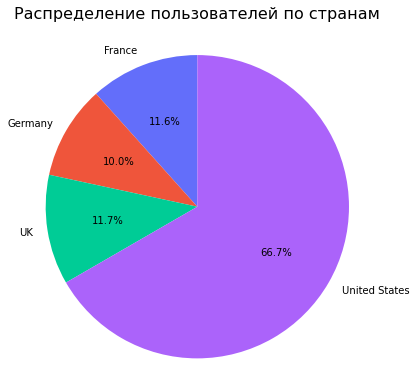

In [23]:
plt.figure(figsize=(6, 6))
plt.pie(region_user_count['users'], labels=region_user_count['region'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'color': 'black'})

plt.title('Распределение пользователей по странам', fontsize=16, pad=25)

plt.axis('equal')
plt.show()

<div class="alert alert-info">Пользователи приходят из 4 стран: США, Великобритания, Франция и Германия. Самая популярная страна - США. Доля пользователей из нее составляет около 67%. Доли остальных стран примерно одинаковы (10-12%).</div>

3.2. Посмотрим на распределение платящих пользователей по странам

In [24]:
region_payers_count = profiles[profiles['payer'] == True].groupby('region').agg({'user_id':'nunique'}).reset_index()
region_payers_count.rename(columns={'user_id': 'payers'}, inplace=True)
region_payers_count = region_payers_count.merge(region_user_count, on='region')
region_payers_count['share'] = round(region_payers_count['payers'] / region_payers_count['users'] * 100,2)

region_payers_count.sort_values(by='payers', ascending=False).reset_index(drop=True)

,region,payers,users,share
0,United States,6902,100002,6.90
1,UK,700,17575,3.98
2,France,663,17450,3.80
3,Germany,616,14981,4.11


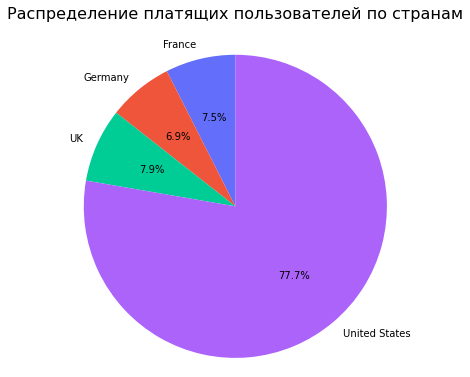

In [25]:
plt.figure(figsize=(6, 6))
plt.pie(region_payers_count['payers'], labels=region_payers_count['region'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'color': 'black'})

plt.title('Распределение платящих пользователей по странам', fontsize=16, pad=25)

plt.axis('equal')
plt.show()

<div class="alert alert-info">Распределение платящих пользователей повторяет распределение всех пользователей. Большую долю занимает США (78%). Около 7% всех пользователей из США становятся покупателями. Доли остальных стран примерно одинаковы, около 7%.</div>

4.1. Посмотрим на распределение пользователей по устройствам

In [26]:
device_user_count = profiles.groupby('device').agg({'user_id':'nunique'}).reset_index()
device_user_count.rename(columns={'user_id': 'users'}, inplace=True)

device_user_count.sort_values(by='users', ascending=False).reset_index(drop=True)

,device,users
0,iPhone,54479
1,Android,35032
2,PC,30455
3,Mac,30042


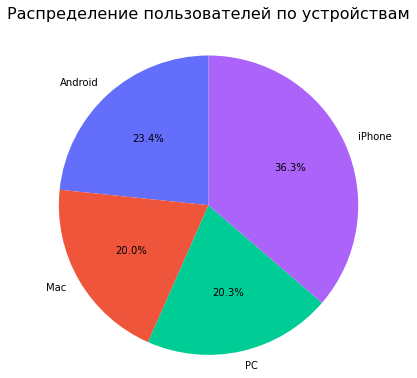

In [27]:
plt.figure(figsize=(6, 6))
plt.pie(device_user_count['users'], labels=device_user_count['device'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'color': 'black'})

plt.title('Распределение пользователей по устройствам', fontsize=16, pad=25)

plt.axis('equal')
plt.show()

<div class="alert alert-info">Пользователи используют 4 устройства: iPhone, Android, PC, Mac. Самая популярное устройство - iPhone. Доля пользователей с этим устройством около 36%. Доли остальных стран примерно одинаковы (20-23%).</div>

4.2. Посмотрим на распределение платящих пользователей по устройствам

In [28]:
device_payers_count = profiles[profiles['payer'] == True].groupby('device').agg({'user_id':'nunique'}).reset_index()
device_payers_count.rename(columns={'user_id': 'payers'}, inplace=True)
device_payers_count = device_payers_count.merge(device_user_count, on='device')
device_payers_count['share'] = round(region_payers_count['payers'] / device_payers_count['users'] * 100,2)

device_payers_count.sort_values(by='payers', ascending=False).reset_index(drop=True)

,device,payers,users,share
0,iPhone,3382,54479,12.67
1,Android,2050,35032,1.89
2,Mac,1912,30042,2.05
3,PC,1537,30455,2.30


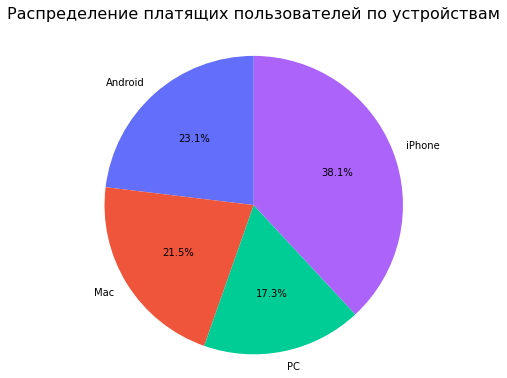

In [29]:
plt.figure(figsize=(6, 6))
plt.pie(device_payers_count['payers'], labels=device_payers_count['device'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'color': 'black'})

plt.title('Распределение платящих пользователей по устройствам', fontsize=16, pad=25)

plt.axis('equal')
plt.show()

<div class="alert alert-info">Распределение платящих пользователей повторяет распределение всех пользователей. Большую долю занимает iPhone (38%). Около 13% всех пользователей, использующих iPhone, становятся покупателями. Доли остальных устройств примерно одинаковы 17-23%.</div>

5.1. Посмотрим на распределение пользователей по каналам привлечения

In [30]:
channel_user_count = profiles.groupby('channel').agg({'user_id':'nunique'}).reset_index()
channel_user_count.rename(columns={'user_id': 'users'}, inplace=True)

channel_user_count = channel_user_count.sort_values(by='users', ascending=False).reset_index(drop=True)
channel_user_count

,channel,users
0,organic,56439
1,FaceBoom,29144
2,TipTop,19561
3,OppleCreativeMedia,8605
4,LeapBob,8553
5,WahooNetBanner,8553
6,RocketSuperAds,4448
7,MediaTornado,4364
8,YRabbit,4312
9,AdNonSense,3880


In [31]:
#Установим цвета
channels = channel_user_count['channel'].unique()
channel_color_dict = {channel: colors[i] for i, channel in enumerate(channels)}

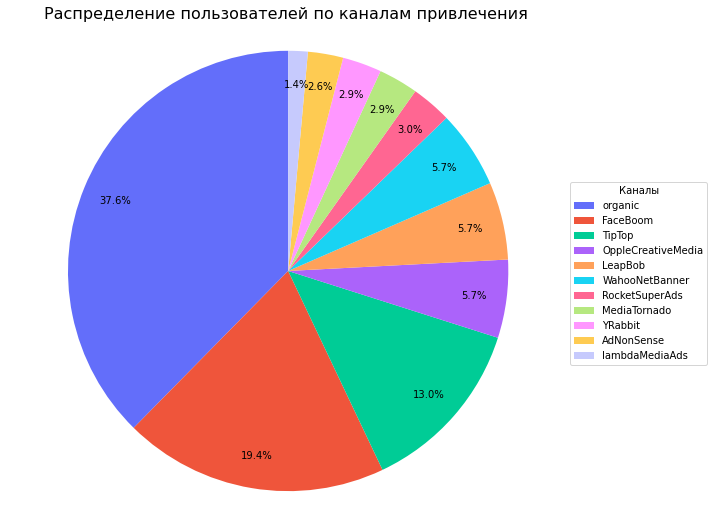

In [32]:
colors_for_plot = [channel_color_dict[channel] for channel in channel_user_count['channel']]

plt.figure(figsize=(10, 9))
plt.pie(channel_user_count['users'],
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors_for_plot,
        textprops={'color': 'black'},
        pctdistance=0.85)

plt.title('Распределение пользователей по каналам привлечения', fontsize=16, pad=10)
plt.axis('equal')
plt.legend(channel_user_count['channel'], title='Каналы', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<div class="alert alert-info">Пользователи приходят по 10 каналам привлечения, также около трети всех пользователей пришли самостоятельно, без канала привлечения. Наиболее популярные каналы: FaceBoom и TipTop</div>

5.2. Посмотрим на распределение платящих пользователей по каналам привлечения

In [33]:
channel_payers_count = profiles[profiles['payer'] == True].groupby('channel').agg({'user_id':'nunique'}).reset_index()
channel_payers_count.rename(columns={'user_id': 'payers'}, inplace=True)
channel_payers_count = channel_payers_count.merge(channel_user_count, on='channel')
channel_payers_count['share'] = round(channel_payers_count['payers'] / channel_payers_count['users'] * 100,2)

channel_payers_count = channel_payers_count.sort_values(by='payers', ascending=False)
channel_payers_count

,channel,payers,users,share
1,FaceBoom,3557,29144,12.20
6,TipTop,1878,19561,9.60
10,organic,1160,56439,2.06
7,WahooNetBanner,453,8553,5.30
0,AdNonSense,440,3880,11.34
5,RocketSuperAds,352,4448,7.91
2,LeapBob,262,8553,3.06
4,OppleCreativeMedia,233,8605,2.71
9,lambdaMediaAds,225,2149,10.47
8,YRabbit,165,4312,3.83


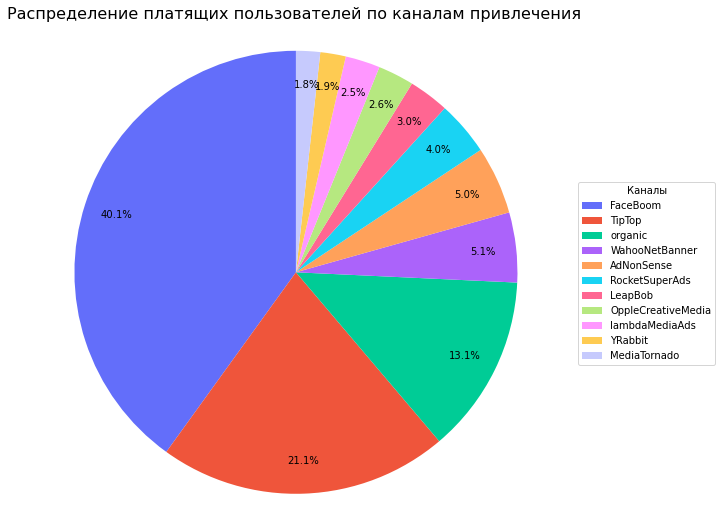

In [34]:
plt.figure(figsize=(10, 9))
plt.pie(channel_payers_count['payers'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors[:len(channel_payers_count)], 
        textprops={'color': 'black'},
        pctdistance=0.85)

plt.title('Распределение платящих пользователей по каналам привлечения', fontsize=16, pad=10)
plt.axis('equal')
plt.legend(channel_payers_count['channel'], title='Каналы', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<div class="alert alert-info">Распределение платящих пользователей отличается от распределения всех пользователей: большая часть приходит по каналу FaceBoom (40%), 21% приходит по каналу TipTop и только 13% самостоятельно. Около 12% пользователей c канала FaceBoom и 10% с канала TipTop становятся покупателями. </div>

### Шаг 4. Маркетинг

1. Посчитаем общую сумму расходов на маркетинг

In [35]:
total_costs = costs['costs'].sum()
print("Общая сумма расходов:", round(total_costs))

Общая сумма расходов: 105497


2. Посмотрим на распределение трат по рекламным каналам

In [36]:
costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending = False).reset_index()
costs_by_channel

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


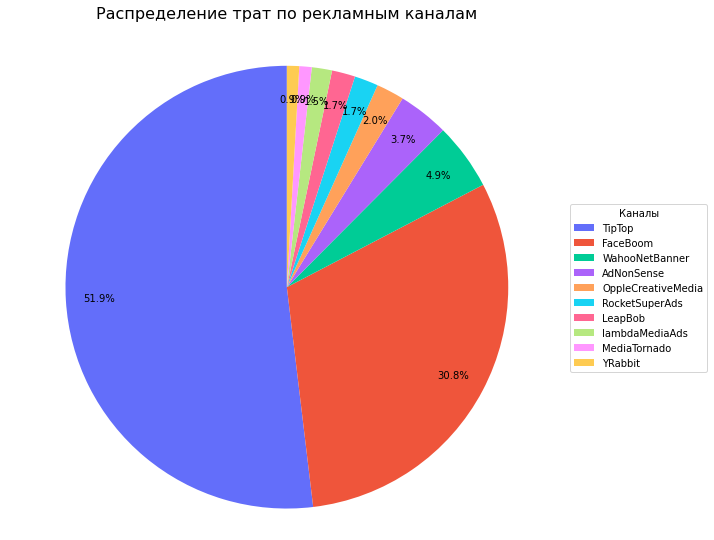

In [37]:
plt.figure(figsize=(10, 9))
plt.pie(costs_by_channel['costs'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors[:len(costs_by_channel)], 
        textprops={'color': 'black'},
        pctdistance=0.85)

plt.title('Распределение трат по рекламным каналам', fontsize=16, pad=25)
plt.axis('equal')
plt.legend(costs_by_channel['channel'], title='Каналы', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<div class="alert alert-info">Больше половины затрат на рекламу приходится на TipTop (55 тысяч), 31% на FaceBoom (32 тысячи), на остальные каналы тратят менее 5%.</div>

3. Посмотрим на динамику изменения расходов 

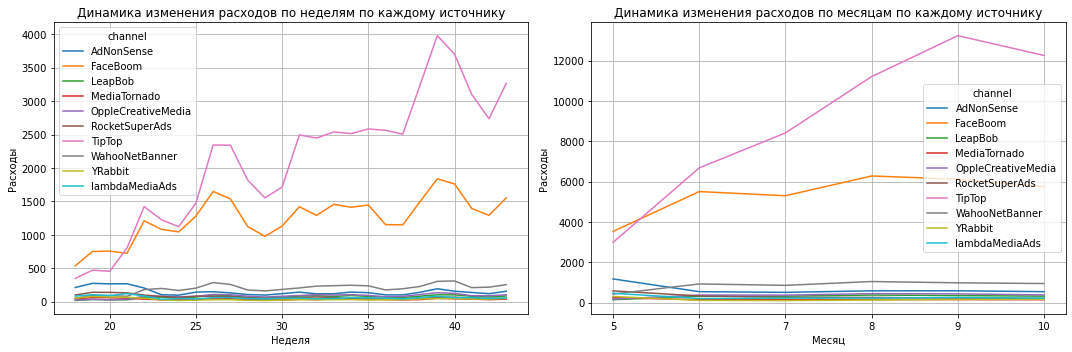

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

costs.pivot_table(
    index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=axes[0])
axes[0].set_xlabel('Неделя')
axes[0].set_ylabel('Расходы')
axes[0].set_title('Динамика изменения расходов по неделям по каждому источнику')

costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=axes[1])
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Расходы')
axes[1].set_title('Динамика изменения расходов по месяцам по каждому источнику')

plt.tight_layout()
plt.show()

<div class="alert alert-info">Расходы на TipTop росли с мая по сентябрь, а затем немного снизились, на FaceBoom с мая немного выросли, но в основном держались на одинаковом уровне. Расходы на остальные каналы оставались почти без изменений.</div>

4. Посчитаем, сколько в среднем стоило привлечение одного пользователя из каждого источника

In [39]:
costs_by_user = costs_by_channel.merge(channel_user_count, on='channel')
costs_by_user['cac'] = round(costs_by_user['costs'] / costs_by_user['users'],2)
costs_by_user = costs_by_user.sort_values(by='cac', ascending=False).reset_index(drop=True)

costs_by_user

,channel,costs,users,cac
0,TipTop,54751.30,19561,2.80
1,FaceBoom,32445.60,29144,1.11
2,AdNonSense,3911.25,3880,1.01
3,lambdaMediaAds,1557.60,2149,0.72
4,WahooNetBanner,5151.00,8553,0.60
5,RocketSuperAds,1833.00,4448,0.41
6,OppleCreativeMedia,2151.25,8605,0.25
7,MediaTornado,954.48,4364,0.22
8,YRabbit,944.22,4312,0.22
9,LeapBob,1797.60,8553,0.21


<div class="alert alert-info">Наибольший CAC у канала TipTop, при этом он почти в три раза больше, чем у остальных каналов. Также высокий CAC у FaceBoom и AdNonSense.</div>

### Шаг 5. Оценим окупаемость рекламы

Для анализа окупаемости рекламы исключим из данных органических пользователей.

1. Проанализируем окупаемость рекламы

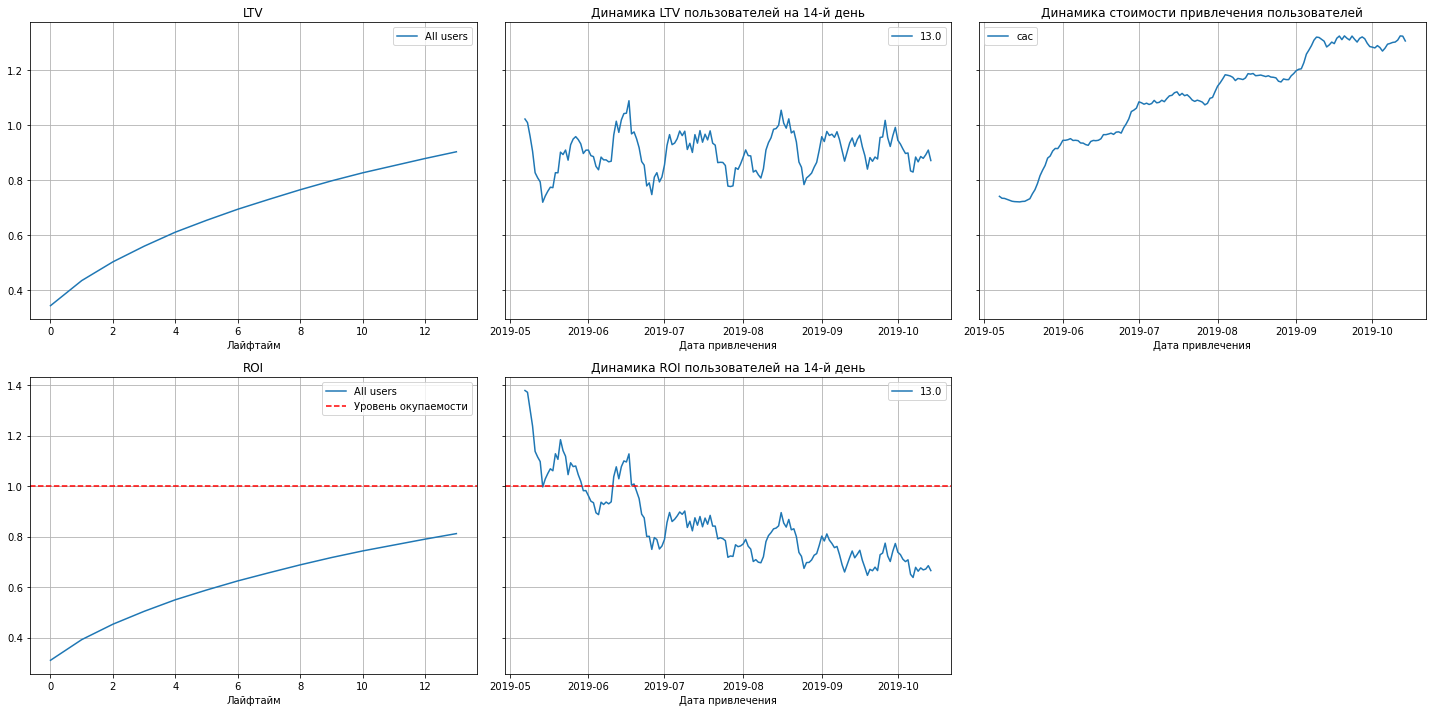

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, analysis_horizon, dimensions=[]
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

<div class="alert alert-info">Стоимость привлечения пользователей за рассматриваемый период растет. График ROI показывает, что реклама в среднем не окупается.</div>

1.1. Проанализируем окупаемость рекламы с разбивкой по устройствам

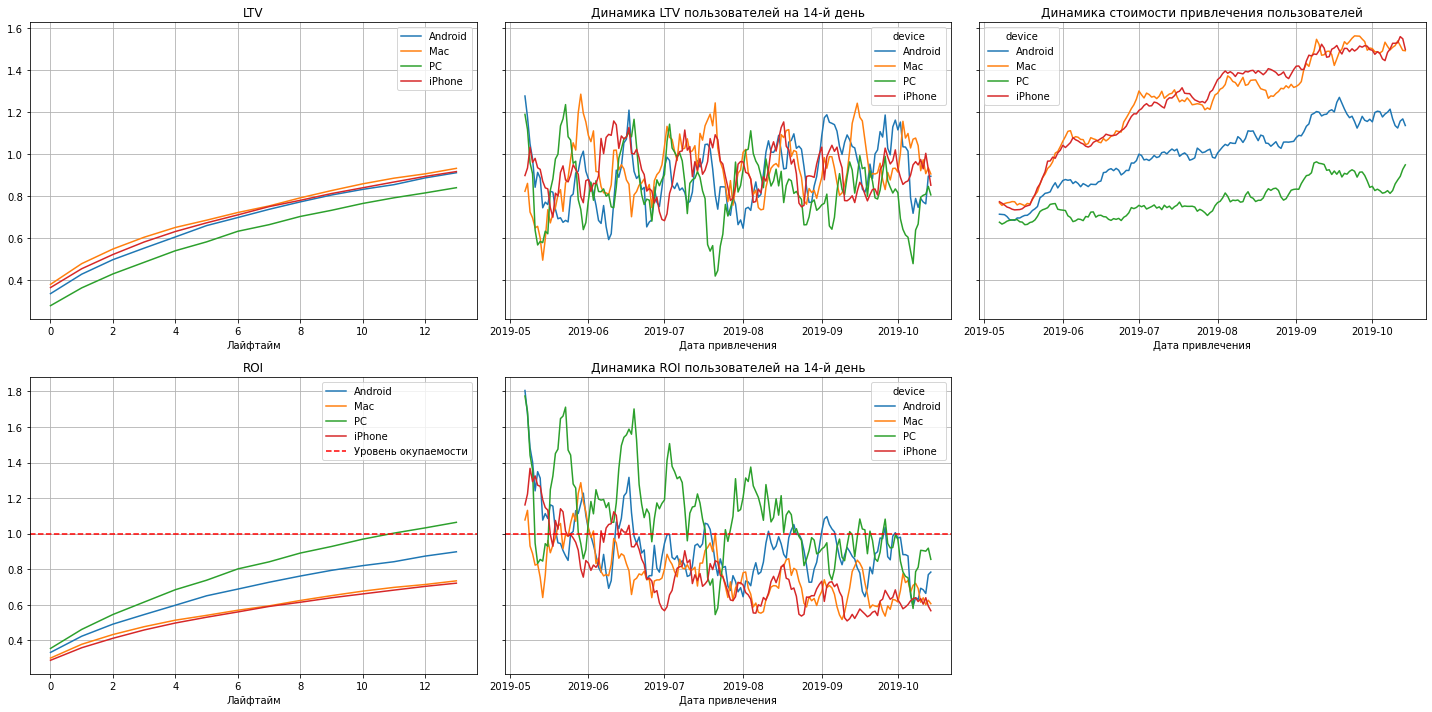

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, analysis_horizon, dimensions=['device']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

<div class="alert alert-info">LTV пользователей примерно одинаков у пользователей разных устройств, однако у PC немного ниже. Стоимость привлечения пользователей всех устройств росла с мая 2019 года. График ROI показывает, что реклама среди пользователей MAC, Android и iPhone не окупается, а среди пользователей PC окупается.</div>

1.2. Проанализируем окупаемость рекламы с разбивкой по странам

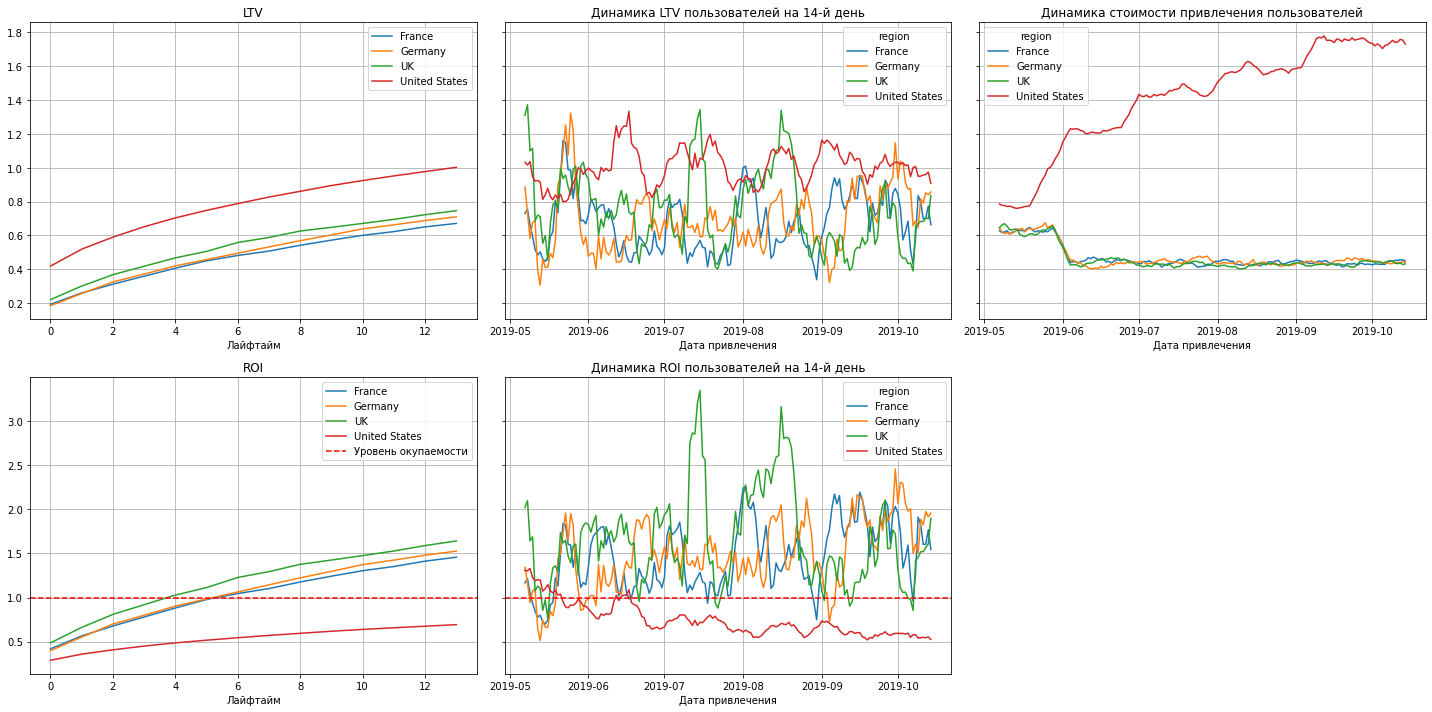

In [42]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, analysis_horizon, dimensions=['region']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

<div class="alert alert-info">Самый высокий LTV у пользователей из США. Стоимость привлечения пользователей из США значительно выросла в июне и продолжила расти, в то время как для остальных стран она снизилась в июне. График ROI показывает, что реклама среди пользователей из США не окупается, а среди остальных стран окупается.</div>

1.3. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

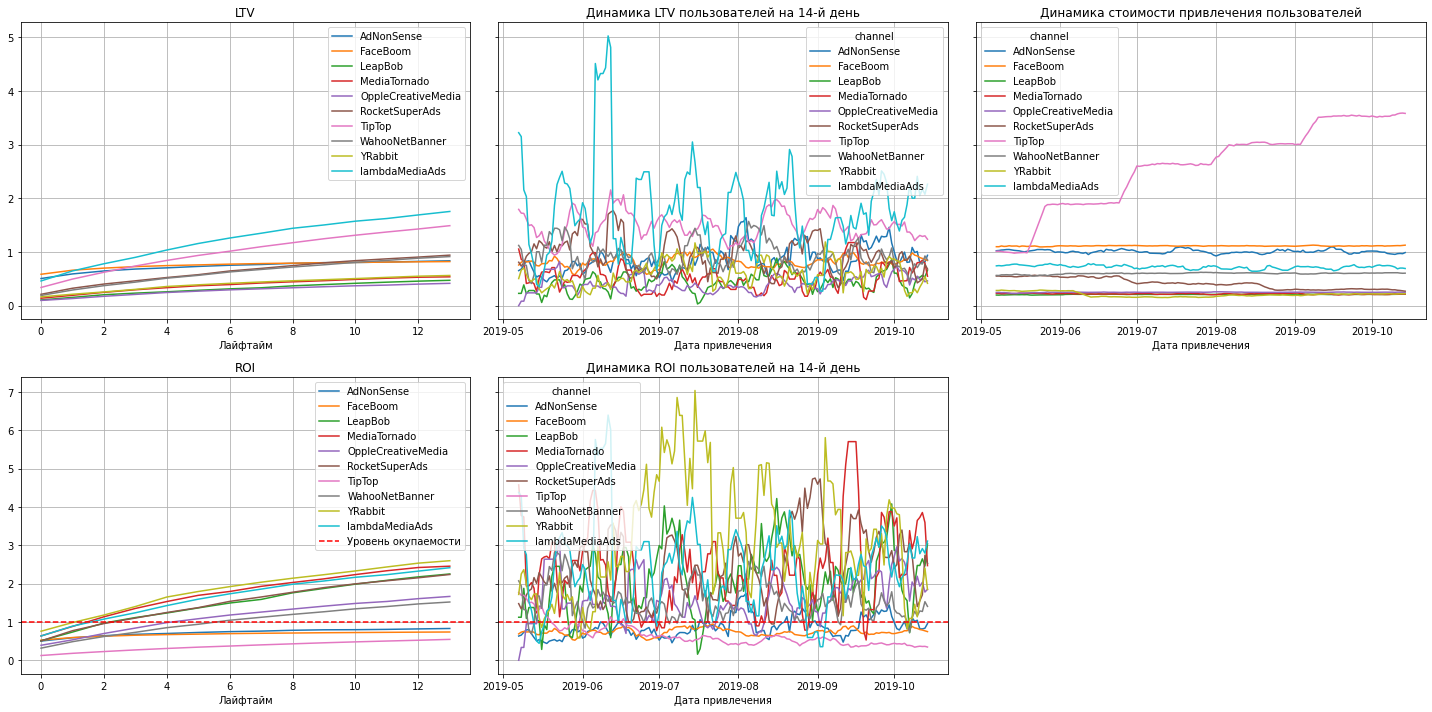

In [43]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, analysis_horizon, dimensions=['channel']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

<div class="alert alert-info">Самый высокий LTV у пользователей с канала IambdaMediaAds. Стоимость привлечения пользователей из TipTop значительно выросла за рассматриваемый период, для остальных почти не изменилась. График ROI показывает, что реклама на каналах TipTop, FaceBoom и AdNonSense не окупается, на остальных окупается.</div>

2. Посмотрим на конверсию и удержание пользователей, а также на динамику их изменения.

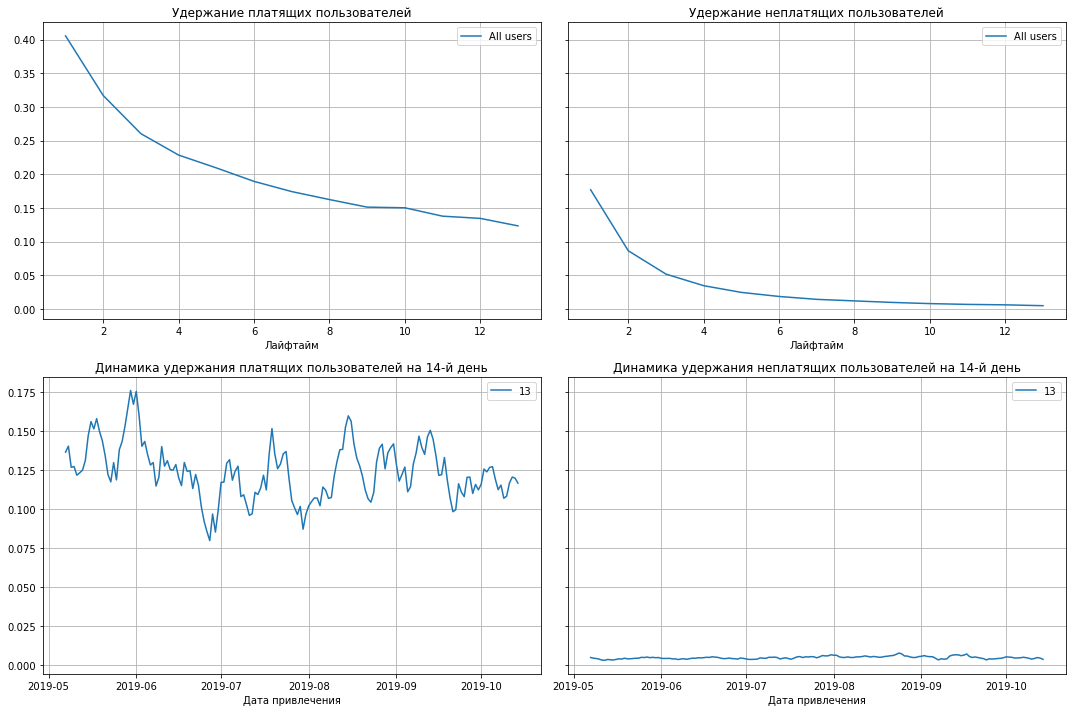

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

<div class="alert alert-info">С увеличением лайфтайма удержание пользователей ожидаемо падает, для неплатящих пользователей к 4 дню оно уже меньше 0.05, а для платящих на 12 день оно держится на уровне 0.13. Динамика удержания неплатящих клиентов на 14 день почти нулевая на протяжении всего периода, а для платящих динамика сильно колеблется: самая высокая точка наблюдается в июне, а самая низкая - в июле. </div>

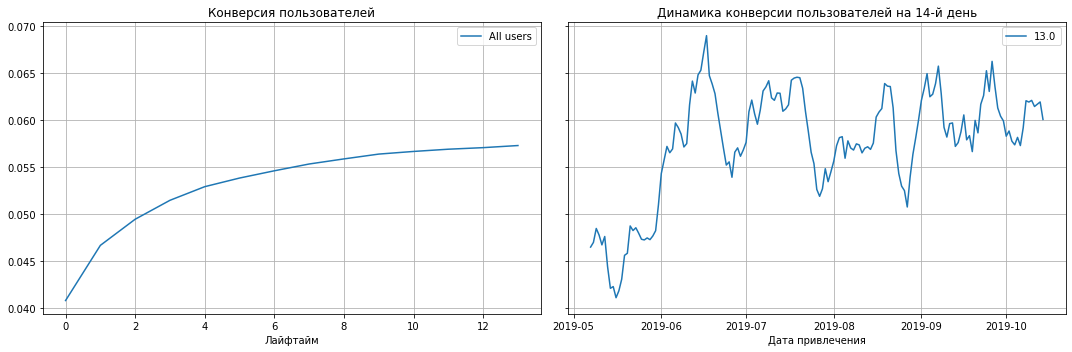

In [45]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon
)

plot_conversion(conversion, conversion_history, analysis_horizon)

<div class="alert alert-info">Конверсия пользователей растет. Низкая конверсия на 14 день наблюдается с мая по июнь, а высокая - с июня по июль.</div>

2.1. Конверсия и удержание пользователей по каналам

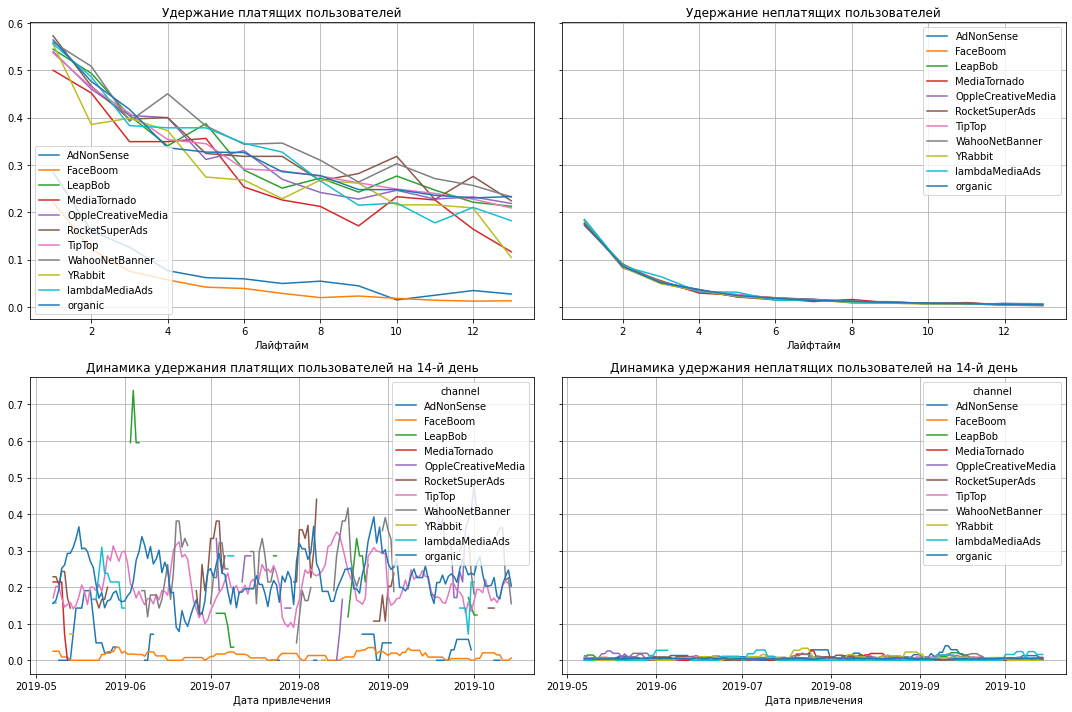

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

<div class="alert alert-info">Удержание платящих пользователей ниже всего по каналу FaceBoom и среди органических пользователей. Удержание неплатящих пользователей одинаково по всем каналам. </div>

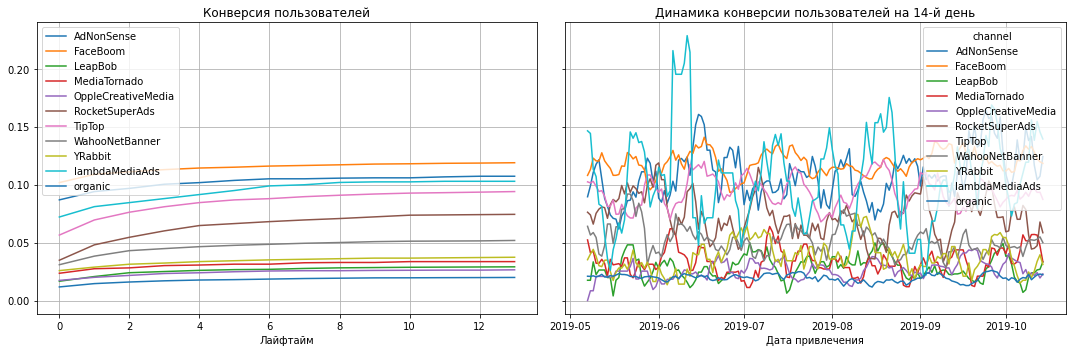

In [47]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, analysis_horizon)

<div class="alert alert-info">Самая низкая конверсия наблюдается у органических пользователей, самая высокая - у канала FaceBoom.</div>

2.2. Конверсия и удержание пользователей по странам

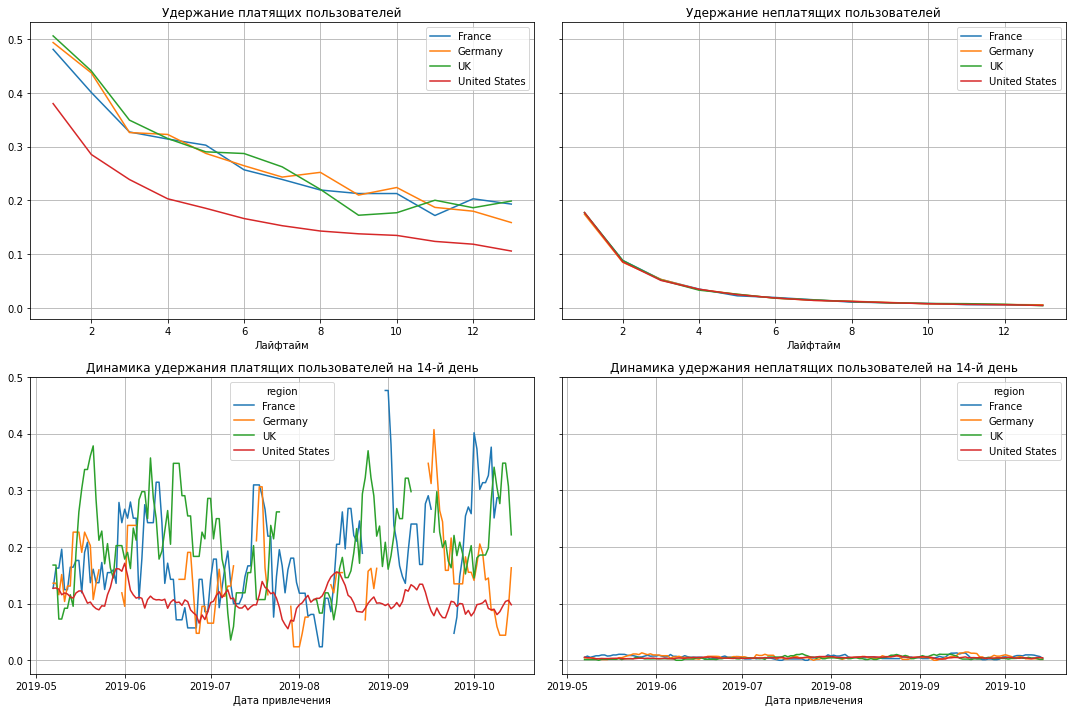

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

<div class="alert alert-info">Удержание платящих пользователей ниже всего в США. Удержание неплатящих пользователей одинаково по всем странам. </div>

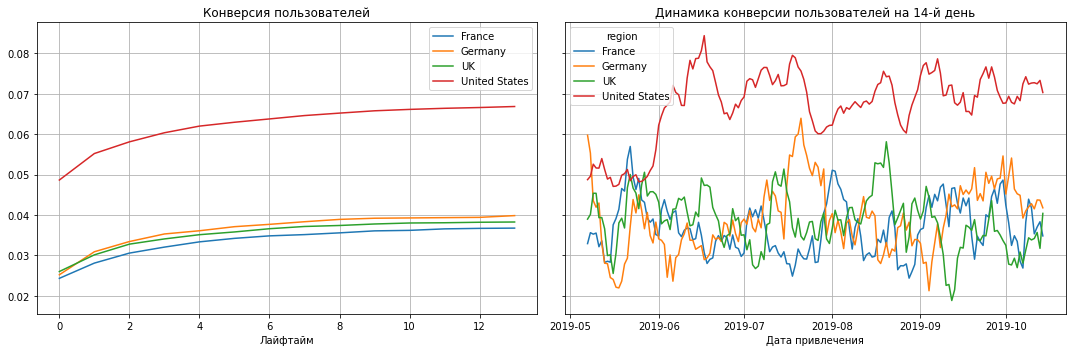

In [49]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region']
)

plot_conversion(conversion, conversion_history, analysis_horizon)

<div class="alert alert-info">Самая низкая конверсия наблюдается у Франции, самая высокая - у США.</div>

2.3. Конверсия и удержание пользователей по устройствам

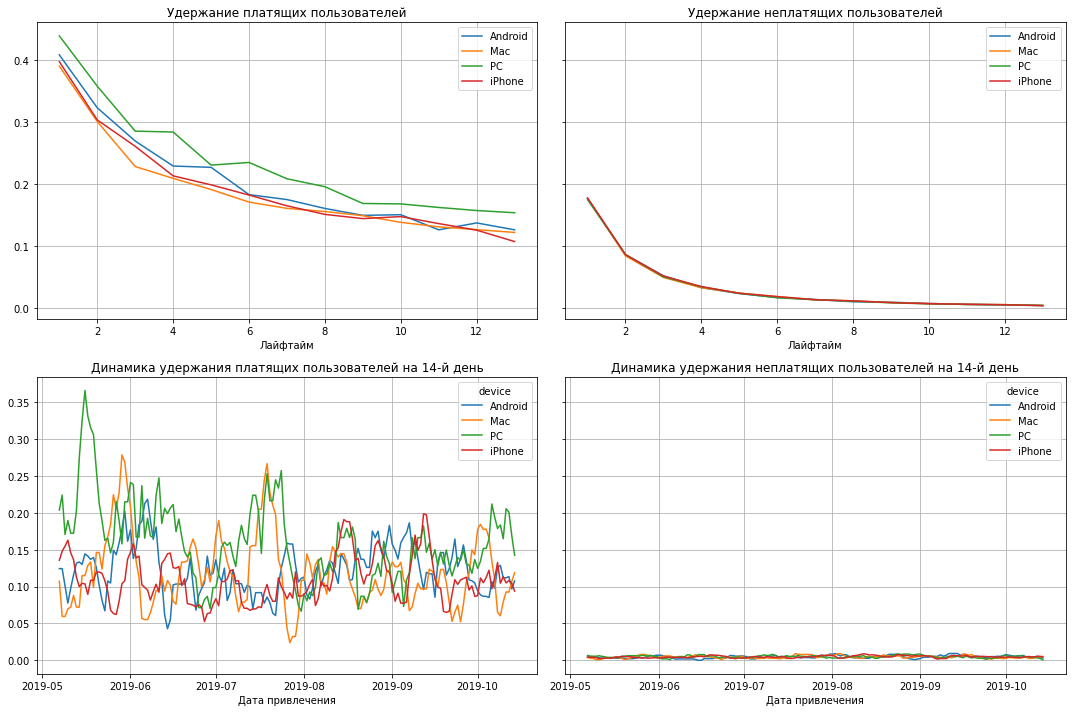

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

<div class="alert alert-info">Удержание платящих пользователей выше всего у PC, у остальных устройств примерно одинаково. Удержание неплатящих пользователей одинаково по всем устройствам. </div>

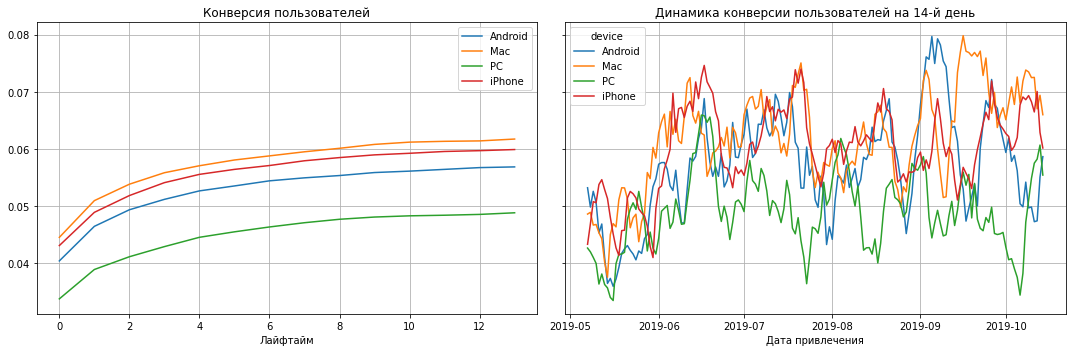

In [51]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device']
)

plot_conversion(conversion, conversion_history, analysis_horizon)

<div class="alert alert-info">Самая низкая конверсия наблюдается у пользователей PC, самая высокая - у MAC.</div>

В целом реклама на привлечение пользователей не окупается. Негативное влияние на окупаемость рекламы оказывают затраты на пользователей США и на каналы TipTop, FaceBoom и AdNonSense. Основная проблема окупаемости в данном случае заключается в излишне больших тратах на маркетинг по данным каналам и стране.</div>

<div class="alert alert-info">
<b/>ОБЩИЙ ВЫВОД</b>
    
В исследовании проанализированы данные по пользователям приложения Procrastinate Pro+ из США, Великобритании, Франции и Германии. 
 
1) По странам 
 
США значительно превосходят другие страны по числу пользователей, включая платящих (примерно 100 тыс. человек), что составляет около 67%. Доля платящих пользователей в США составляет около 7%. Однако рекламные затраты окупаются во всех странах, кроме США. При этом конверсия в США выше, чем в остальных странах, но удержание - ниже.  
 
2) По устройствам 
 
Самым популярным устройством среди пользователей (как платящих, так и нет) является iPhone (38% и 36% соответственно). Доля платящих пользователей iPhone - 13%. Рекламные затраты окупаются только у пользователей PC. При этом конверсия среди пользователей PC самая низкая, а  удержание выше, чем на остальных устройствах. 
 
3) По каналам привлечения 
 
Доля органических пользователей составляет 37% от общего числа пользователей, при этом большая часть платящих пользователей приходит по каналу FaceBoom (40%). Около 12% пользователей c канала FaceBoom и 10% с канала TipTop становятся покупателями. TipTop и FaceBoom – наиболее затратные каналы. Привлечение одного пользователя из канала TipTop - 2.8 и FaceBoom – 1,11 ед. Рекламные затраты окупаются у всех каналов, кроме TipTop, FaceBoom и AdNonSense. Самая высокая конверсия у канала FaceBoom, но удержание клиентов, пришедших по нему, самое низкое.
 

 
<br> В целом, рекламные усилия по привлечению пользователей не оправдали себя из-за излишних расходов на маркетинг. Для успешного привлечения стоимость рекламы должна быть оптимальной. К примеру, вложения оказались оправданными в отношении пользователей PC и в таких странах, как Франция, Германия и Великобритания. Из 10 каналов привлечения, ROI 7 также превысили уровень окупаемости. 
 
Отделу маркетинга приложения Procrastinate Pro+ рекомендуется уменьшить финансирование рекламы в случаях, где стоимость привлечения слишком большая - это расходы на пользователей из США и канал TipTop. Пользователи из США на всех устройствах не приносили достаточной прибыли, при непрерывном увеличении затрат на их привлечение. Это следует учесть при принятии решений о финансировании и обоснованности данных расходов.</div>